- Predictions of the future
- Graphics of every variable
  - one color the ground truth and another color the predictions
- Combination with the classes to see the specific co2, temperature and humidity in every class
- Take the errors and compute 'la mitjana' and if it is smaller, we can consider it a good prediction
- Test set to see how our model is performing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Load data from CSV
data = pd.read_csv('Sensors_cleansed.csv')

print(data)
print(data.shape)
unique_days = data['day'].nunique()
print("Número de días únicos:", unique_days)



                  location         day       sensor  Average Daily Value
0        am3019-testqc2090  2023-07-25          co2           463.457627
1        am3019-testqc2090  2023-07-25     humidity            40.042373
2        am3019-testqc2090  2023-07-25  temperature            26.600000
3        am3019-testqc2090  2023-07-26          co2           480.809859
4        am3019-testqc2090  2023-07-26     humidity            44.140845
...                    ...         ...          ...                  ...
2654  eui-24e124128c147499  2023-10-25          co2           741.734375
2655  eui-24e124128c147499  2023-10-26          co2           928.165414
2656  eui-24e124128c147499  2023-10-27          co2           680.000000
2657  eui-24e124128c147499  2023-10-28          co2           561.024000
2658  eui-24e124128c147499  2023-10-29          co2           502.111111

[2659 rows x 4 columns]
(2659, 4)
Número de días únicos: 231


In [ ]:
data['day'] = pd.to_datetime(data['day'])

# Pivot the table to get each sensor as a column
data_pivot = data.pivot_table(index=['day', 'location'], columns='sensor', values='Average Daily Value', aggfunc='mean')
print(data_pivot)

# Fill missing values if any
data_pivot = data_pivot.fillna(method='ffill')

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_pivot)

# print(data_scaled)

def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Define number of time steps
n_steps = 10

# Split data into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = data_scaled[:split], data_scaled[split:]
print(X_train.shape, X_test.shape)

sensor                                  co2   humidity  temperature
day        location                                                
2023-07-25 am3019-testqc2090     463.457627  40.042373    26.600000
           am307-9074            420.442623  41.204918    26.219672
           eui-24e124128c147204  485.491525  49.135593    25.552542
           eui-24e124128c147444  396.022727  49.284091    25.934091
           eui-24e124128c147499  514.527273  56.527273          NaN
...                                     ...        ...          ...
2024-03-30 am3019-testqc2090     451.219178  40.691781    22.121918
           am307-9074            396.826667  41.460000    21.970667
           eui-24e124128c147204  450.388889  60.312500    19.458333
           eui-24e124128c147446  457.729730  41.628378    21.825676
           eui-24e124128c147470  443.445946  41.601351    21.913514

[941 rows x 3 columns]
(752, 3) (189, 3)


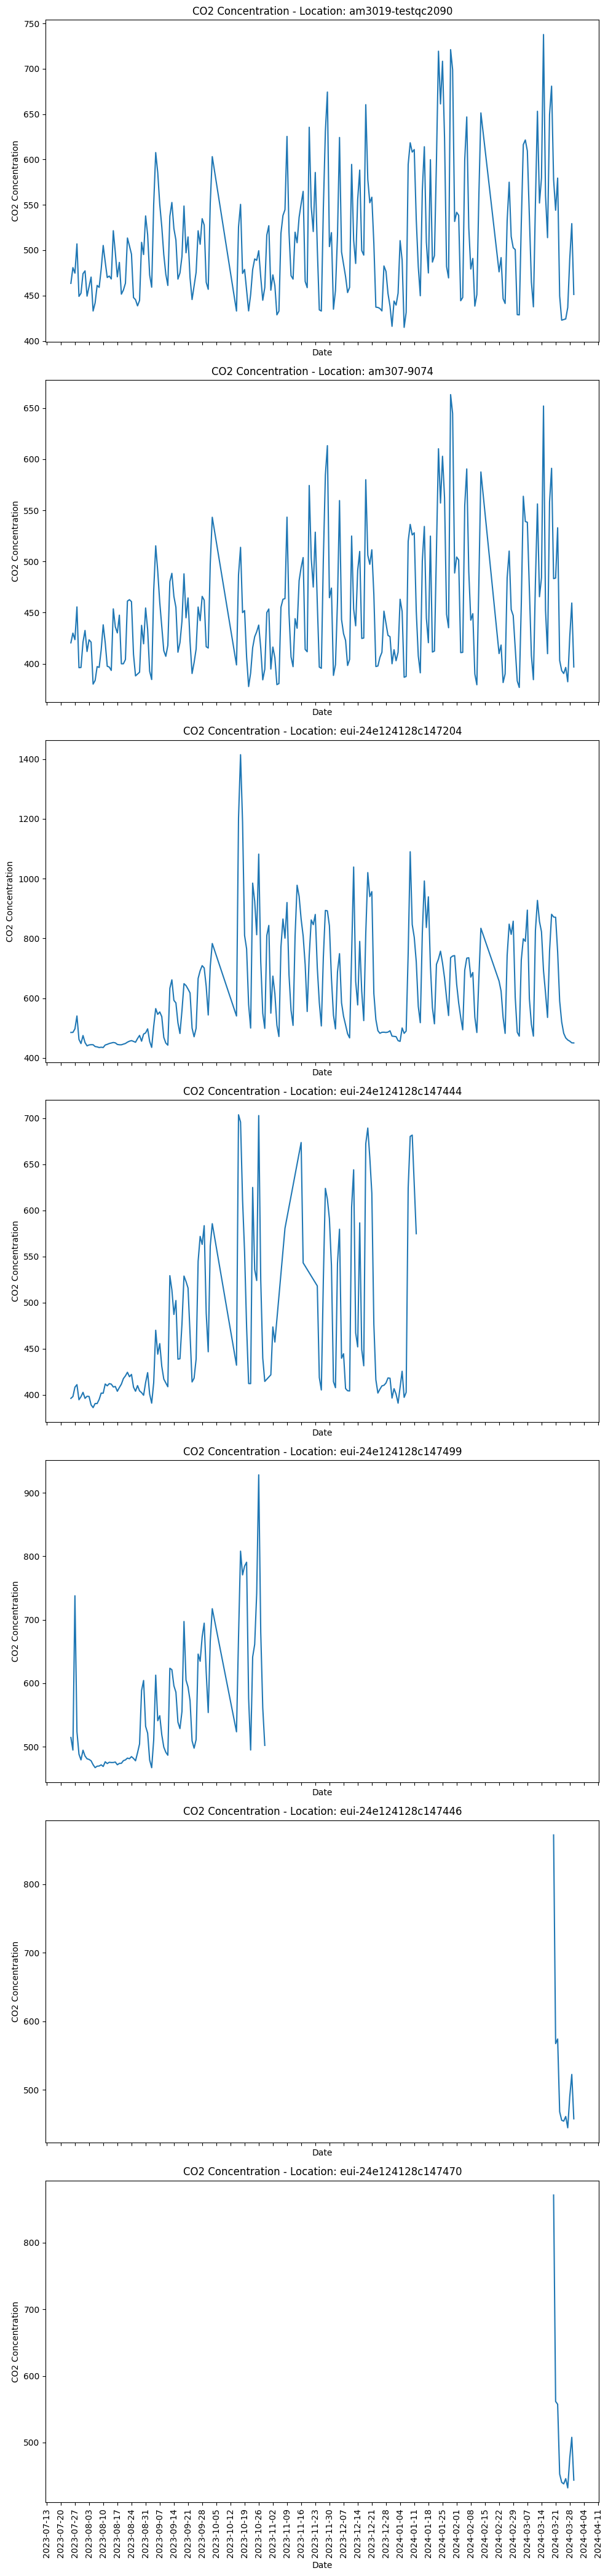

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Obtener las ubicaciones
locations = data_pivot.index.get_level_values('location').unique()

# Crear subgráficos para cada ubicación
fig, axs = plt.subplots(len(locations), figsize=(10, 6 * len(locations)), sharex=True)

for i, location in enumerate(locations):
    # Seleccionar datos de CO2 para la ubicación actual
    co2_data = data_pivot.loc[data_pivot.index.get_level_values('location') == location, 'co2']

    # Convertir el índice de fechas a un formato de fecha válido
    dates = pd.to_datetime([date[0] for date in co2_data.index])

    # Visualizar la serie temporal de CO2
    axs[i].plot(dates, co2_data.values, linestyle='solid', marker=None)
    axs[i].set_title(f'CO2 Concentration - Location: {location}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('CO2 Concentration')
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato de las fechas
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Intervalo de etiquetas de fecha

    # Girar etiquetas del eje x
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


#Co2 levels

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np

co2_index = list(data_pivot.columns).index('co2')
X_co2, y_co2 = prepare_data(data_scaled[:, co2_index], n_steps)
X_co2_train, X_co2_test = X_co2[:split], X_co2[split:]
y_co2_train, y_co2_test = y_co2[:split], y_co2[split:]
# Reshape X_co2_train and X_co2_test to include time steps dimension
X_co2_train = X_co2_train.reshape(X_co2_train.shape[0], X_co2_train.shape[1], 1)
X_co2_test = X_co2_test.reshape(X_co2_test.shape[0], X_co2_test.shape[1], 1)

y_co2_train = y_co2_train.reshape(-1, 1)
y_co2_test = y_co2_test.reshape(-1, 1)

model_co2 = Sequential()
model_co2.add(LSTM(370, activation='relu', return_sequences=True, input_shape=(X_co2_train.shape[1], 1)))
model_co2.add(Dropout(0.2))
model_co2.add(LSTM(370, activation='relu'))
model_co2.add(Dropout(0.2))
model_co2.add(Dense(1, kernel_regularizer=l2(0.01)))




optimizer = Adam(learning_rate=0.0001)
model_co2.compile(optimizer=optimizer, loss='mse')
history = model_co2.fit(X_co2_train, y_co2_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_co2_test, y_co2_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

predictions_co2 = model_co2.predict(X_co2_test)
predictions_co2 = predictions_co2.reshape(-1, 1)
print("Predictions CO2 shape:", predictions_co2.shape)
# Inverse transform the predictions for CO2
predictions_co2_inv = scaler.inverse_transform(np.concatenate((predictions_co2, np.zeros((len(predictions_co2), 2))), axis=1))[:, 0]
print("CO2 predictions:")
print(predictions_co2_inv)


Epoch 1/100
24/24 [==============================] - 4s 89ms/step - loss: 0.0473 - val_loss: 0.0421
Epoch 2/100
24/24 [==============================] - 2s 77ms/step - loss: 0.0341 - val_loss: 0.0337
Epoch 3/100
24/24 [==============================] - 2s 77ms/step - loss: 0.0319 - val_loss: 0.0326
Epoch 4/100
24/24 [==============================] - 2s 76ms/step - loss: 0.0305 - val_loss: 0.0316
Epoch 5/100
24/24 [==============================] - 2s 103ms/step - loss: 0.0296 - val_loss: 0.0308
Epoch 6/100
24/24 [==============================] - 2s 85ms/step - loss: 0.0285 - val_loss: 0.0299
Epoch 7/100
24/24 [==============================] - 2s 76ms/step - loss: 0.0279 - val_loss: 0.0291
Epoch 8/100
24/24 [==============================] - 2s 76ms/step - loss: 0.0270 - val_loss: 0.0285
Epoch 9/100
24/24 [==============================] - 2s 77ms/step - loss: 0.0262 - val_loss: 0.0277
Epoch 10/100
24/24 [==============================] - 2s 77ms/step - loss: 0.0255 - val_loss: 0.026

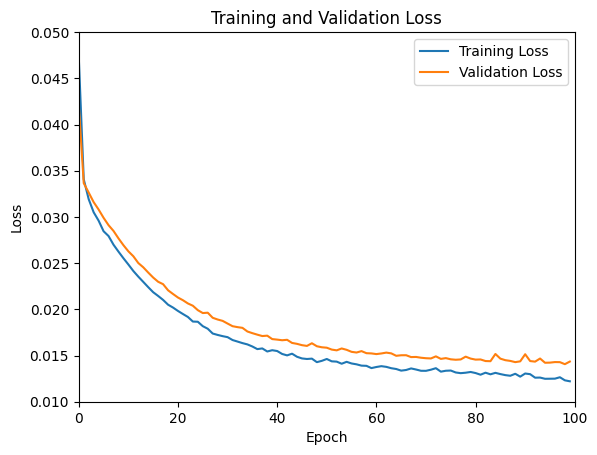

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0.01, 0.05)  # Adjust the y-axis range here
plt.xlim(0, 100)
plt.legend()
plt.show()

In [ ]:
# Print the predicted and ground truth CO2 values
# Inverse transform the ground truth for CO2
y_co2_test_inv = scaler.inverse_transform(np.concatenate((y_co2_test, np.zeros((len(y_co2_test), 2))), axis=1))[:, 0]

# Print the predicted and ground truth CO2 values
print("Predicted CO2\tGround Truth CO2")
for pred, truth in zip(predictions_co2_inv, y_co2_test_inv):
    print('predictions:', pred, 'ground truth:', truth)



Predicted CO2	Ground Truth CO2
predictions: 573.1464488871834 ground truth: 698.9927536231884
predictions: 613.2607647932224 ground truth: 644.7887323943662
predictions: 650.582833297989 ground truth: 741.1363636363636
predictions: 665.6626859530065 ground truth: 531.6619718309859
predictions: 635.7760732493115 ground truth: 488.7142857142857
predictions: 602.7705165639655 ground truth: 742.6062992125984
predictions: 570.2300122442693 ground truth: 541.7816901408451
predictions: 549.391536932206 ground truth: 504.3169014084507
predictions: 527.7538582264838 ground truth: 647.1307692307693
predictions: 530.3899798003123 ground truth: 538.3758865248227
predictions: 550.1525092168564 ground truth: 501.4347826086956
predictions: 543.2335909601925 ground truth: 584.2
predictions: 546.7919607105569 ground truth: 444.2867132867133
predictions: 527.7457078241993 ground truth: 410.8450704225352
predictions: 507.09017579225804 ground truth: 536.0
predictions: 502.55813454923594 ground truth: 447

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse_co2 = mean_squared_error(y_co2_test_inv, predictions_co2_inv)
print("Mean Squared Error (CO2):", mse_co2)


Mean Squared Error (CO2): 15030.30517940707


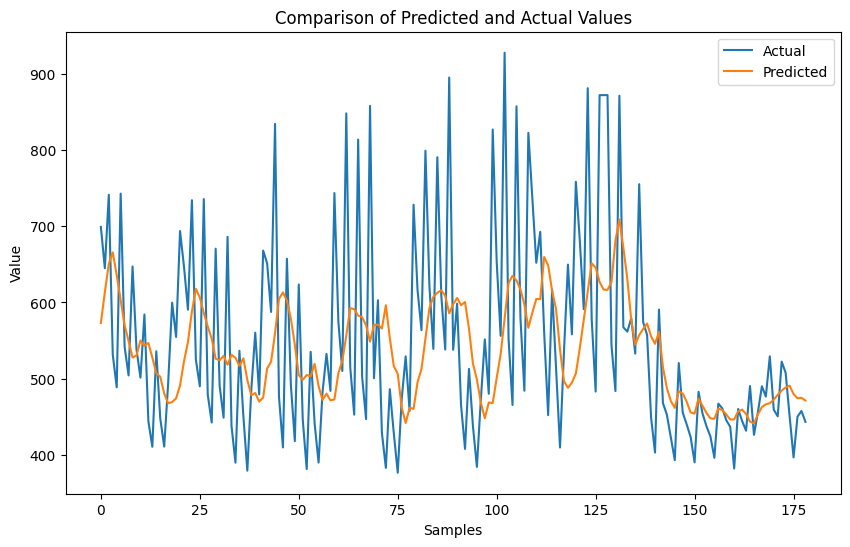

In [ ]:
# Flatten X_co2_test
y_co2_test_flat = scaler.inverse_transform(np.concatenate((y_co2_test, np.zeros((len(y_co2_test), 2))), axis=1))[:, 0]
y_co2_test_flat = y_co2_test_flat.reshape(-1)

# Plot comparison of predicted and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_co2_test_flat, label='Actual')
plt.plot(predictions_co2_inv, label='Predicted')
plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# unique_locations = data_pivot.index.get_level_values('location').unique()

# for location in unique_locations:
#     # Filtrar datos por ubicación
#     data_location = data_pivot.loc[data_pivot.index.get_level_values('location') == location]

#     # Escalar datos específicos de la ubicación
#     scaler_location = MinMaxScaler()
#     data_location_2d = data_location.values.reshape(-1, 1)
#     data_scaled_location = scaler_location.fit_transform(data_location_2d)

#     # Preparar datos para LSTM
#     X_co2_location, y_co2_location = prepare_data(data_scaled_location[:, co2_index], n_steps)

#     # Dividir datos en entrenamiento y prueba
#     split_location = int(0.8 * len(X_co2_location))
#     X_co2_train_location, X_co2_test_location = X_co2_location[:split_location], X_co2_location[split_location:]
#     y_co2_train_location, y_co2_test_location = y_co2_location[:split_location], y_co2_location[split_location:]

#     # Reshape para incluir la dimensión de pasos de tiempo
#     X_co2_train_location = X_co2_train_location.reshape(X_co2_train_location.shape[0], X_co2_train_location.shape[1], 1)
#     X_co2_test_location = X_co2_test_location.reshape(X_co2_test_location.shape[0], X_co2_test_location.shape[1], 1)

#     y_co2_train_location = y_co2_train_location.reshape(-1, 1)
#     y_co2_test_location = y_co2_test_location.reshape(-1, 1)

#     # Crear y compilar el modelo LSTM para esta ubicación
#     model_co2_location = Sequential()
#     model_co2_location.add(LSTM(370, activation='relu', return_sequences=True, input_shape=(X_co2_train_location.shape[1], 1)))
#     model_co2_location.add(Dropout(0.2))
#     model_co2_location.add(LSTM(370, activation='relu'))
#     model_co2_location.add(Dropout(0.2))
#     model_co2_location.add(Dense(1, kernel_regularizer=l2(0.01)))

#     optimizer_location = Adam(learning_rate=0.0001)
#     model_co2_location.compile(optimizer=optimizer_location, loss='mse')

#     # Entrenar el modelo para esta ubicación
#     history_location = model_co2_location.fit(X_co2_train_location, y_co2_train_location, epochs=100, batch_size=32, verbose=1, validation_data=(X_co2_test_location, y_co2_test_location), callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

#     # Predecir CO2 para esta ubicación
#     predictions_co2_location = model_co2_location.predict(X_co2_test_location)
#     predictions_co2_location = predictions_co2_location.reshape(-1, 1)

#     # Transformar las predicciones de vuelta a la escala original
#     predictions_co2_location_inv = scaler_location.inverse_transform(np.concatenate((predictions_co2_location, np.zeros((len(predictions_co2_location), 2))), axis=1))[:, 0]

#     # Imprimir las predicciones para esta ubicación
#     print("Predictions CO2 for location", location, ":", predictions_co2_location_inv)


Epoch 1/100
18/18 [==============================] - 4s 120ms/step - loss: 0.1650 - val_loss: 0.1570
Epoch 2/100
18/18 [==============================] - 1s 77ms/step - loss: 0.1344 - val_loss: 0.1278
Epoch 3/100
18/18 [==============================] - 1s 78ms/step - loss: 0.1197 - val_loss: 0.1275
Epoch 4/100
18/18 [==============================] - 1s 79ms/step - loss: 0.1189 - val_loss: 0.1261
Epoch 5/100
18/18 [==============================] - 1s 78ms/step - loss: 0.1180 - val_loss: 0.1252
Epoch 6/100
18/18 [==============================] - 1s 78ms/step - loss: 0.1183 - val_loss: 0.1246
Epoch 7/100
18/18 [==============================] - 1s 78ms/step - loss: 0.1171 - val_loss: 0.1239
Epoch 8/100
18/18 [==============================] - 2s 104ms/step - loss: 0.1159 - val_loss: 0.1234
Epoch 9/100
18/18 [==============================] - 2s 102ms/step - loss: 0.1153 - val_loss: 0.1228
Epoch 10/100
18/18 [==============================] - 1s 79ms/step - loss: 0.1148 - val_loss: 0.1

1/1 [==============================] - 0s 224ms/step
Predictions CO2 for location eui-24e124128c147470 : [189.08091596 173.72904789 180.27858889 191.4862953  176.35668542]


##Co2 per location

Epoch 1/100
6/6 [==============================] - 4s 87ms/step - loss: 0.1145 - val_loss: 0.3264
Epoch 2/100
6/6 [==============================] - 0s 30ms/step - loss: 0.1098 - val_loss: 0.3154
Epoch 3/100
6/6 [==============================] - 0s 29ms/step - loss: 0.1052 - val_loss: 0.3037
Epoch 4/100
6/6 [==============================] - 0s 29ms/step - loss: 0.1004 - val_loss: 0.2913
Epoch 5/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0954 - val_loss: 0.2779
Epoch 6/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0895 - val_loss: 0.2632
Epoch 7/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0838 - val_loss: 0.2472
Epoch 8/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0778 - val_loss: 0.2300
Epoch 9/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0710 - val_loss: 0.2119
Epoch 10/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0647 - val_loss: 0.1931
Epoch 11/100
6/6 [=

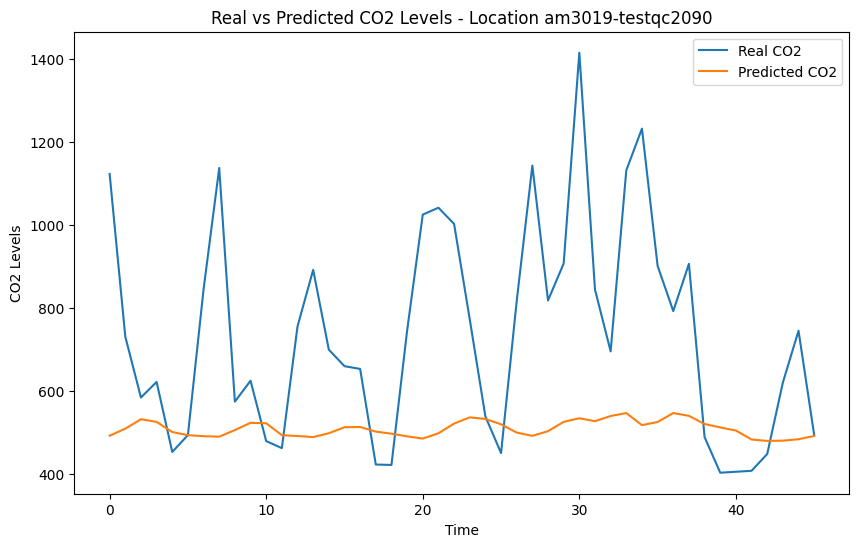

Epoch 1/100
6/6 [==============================] - 2s 84ms/step - loss: 0.0991 - val_loss: 0.3009
Epoch 2/100
6/6 [==============================] - 0s 48ms/step - loss: 0.0956 - val_loss: 0.2918
Epoch 3/100
6/6 [==============================] - 0s 52ms/step - loss: 0.0920 - val_loss: 0.2824
Epoch 4/100
6/6 [==============================] - 0s 51ms/step - loss: 0.0885 - val_loss: 0.2723
Epoch 5/100
6/6 [==============================] - 0s 50ms/step - loss: 0.0845 - val_loss: 0.2612
Epoch 6/100
6/6 [==============================] - 0s 47ms/step - loss: 0.0804 - val_loss: 0.2488
Epoch 7/100
6/6 [==============================] - 0s 52ms/step - loss: 0.0760 - val_loss: 0.2353
Epoch 8/100
6/6 [==============================] - 0s 46ms/step - loss: 0.0711 - val_loss: 0.2216
Epoch 9/100
6/6 [==============================] - 0s 45ms/step - loss: 0.0665 - val_loss: 0.2065
Epoch 10/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0617 - val_loss: 0.1924
Epoch 11/100
6/6 [=

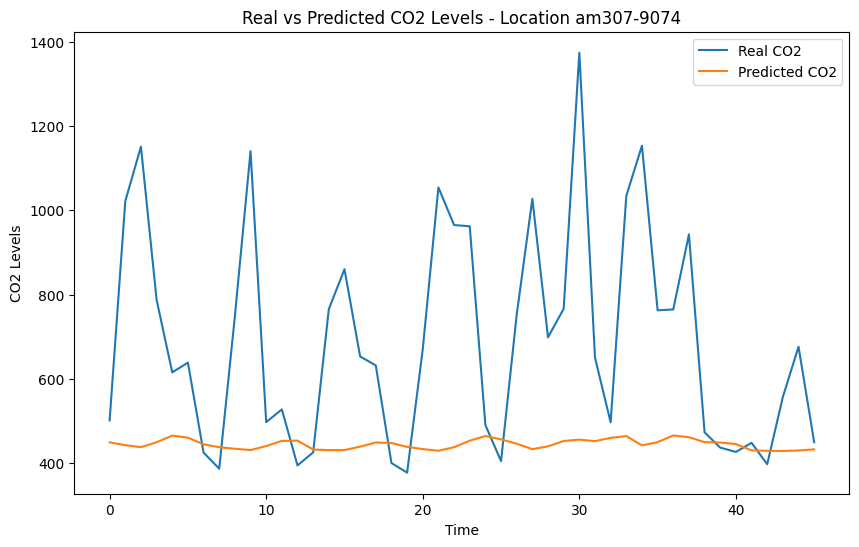

Epoch 1/100
6/6 [==============================] - 2s 85ms/step - loss: 0.0948 - val_loss: 0.0832
Epoch 2/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0916 - val_loss: 0.0797
Epoch 3/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0886 - val_loss: 0.0760
Epoch 4/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0856 - val_loss: 0.0722
Epoch 5/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0823 - val_loss: 0.0683
Epoch 6/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0790 - val_loss: 0.0642
Epoch 7/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0754 - val_loss: 0.0599
Epoch 8/100
6/6 [==============================] - 0s 45ms/step - loss: 0.0722 - val_loss: 0.0555
Epoch 9/100
6/6 [==============================] - 0s 49ms/step - loss: 0.0681 - val_loss: 0.0507
Epoch 10/100
6/6 [==============================] - 0s 45ms/step - loss: 0.0643 - val_loss: 0.0457
Epoch 11/100
6/6 [=

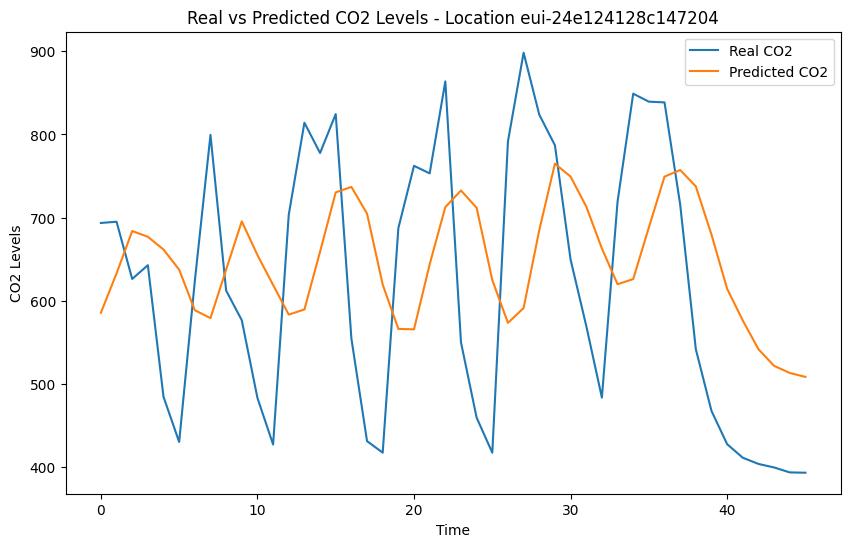

Epoch 1/100
4/4 [==============================] - 4s 598ms/step - loss: 0.1477 - val_loss: 0.2102
Epoch 2/100
4/4 [==============================] - 0s 38ms/step - loss: 0.1441 - val_loss: 0.2059
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 0.1409 - val_loss: 0.2019
Epoch 4/100
4/4 [==============================] - 0s 61ms/step - loss: 0.1378 - val_loss: 0.1979
Epoch 5/100
4/4 [==============================] - 0s 57ms/step - loss: 0.1343 - val_loss: 0.1938
Epoch 6/100
4/4 [==============================] - 0s 58ms/step - loss: 0.1310 - val_loss: 0.1895
Epoch 7/100
4/4 [==============================] - 0s 56ms/step - loss: 0.1275 - val_loss: 0.1850
Epoch 8/100
4/4 [==============================] - 0s 53ms/step - loss: 0.1240 - val_loss: 0.1804
Epoch 9/100
4/4 [==============================] - 0s 58ms/step - loss: 0.1204 - val_loss: 0.1755
Epoch 10/100
4/4 [==============================] - 0s 59ms/step - loss: 0.1160 - val_loss: 0.1702
Epoch 11/100
4/4 [

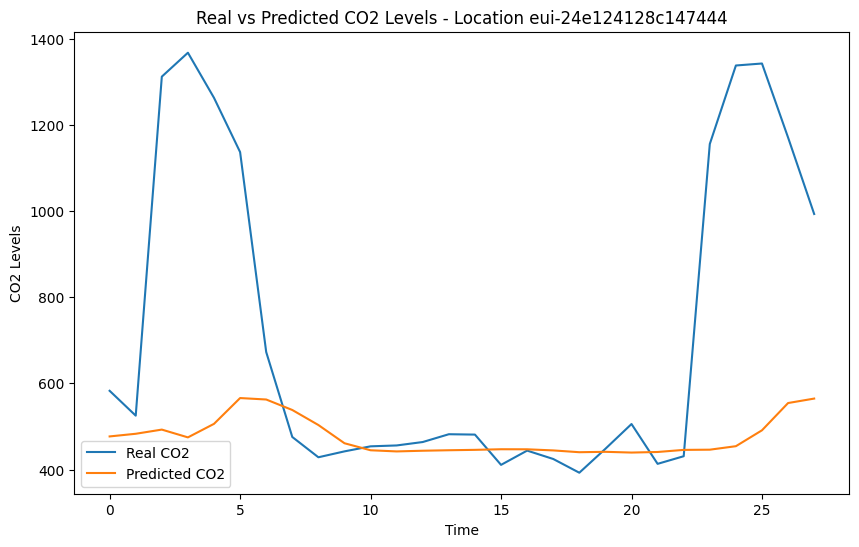

Epoch 1/100
2/2 [==============================] - 2s 337ms/step - loss: 0.0432 - val_loss: 0.1429
Epoch 2/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0426 - val_loss: 0.1411
Epoch 3/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0422 - val_loss: 0.1394
Epoch 4/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0416 - val_loss: 0.1376
Epoch 5/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0412 - val_loss: 0.1359
Epoch 6/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0407 - val_loss: 0.1342
Epoch 7/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0401 - val_loss: 0.1324
Epoch 8/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0397 - val_loss: 0.1306
Epoch 9/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0391 - val_loss: 0.1288
Epoch 10/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0387 - val_loss: 0.1269
Epoch 11/100
2/2 [

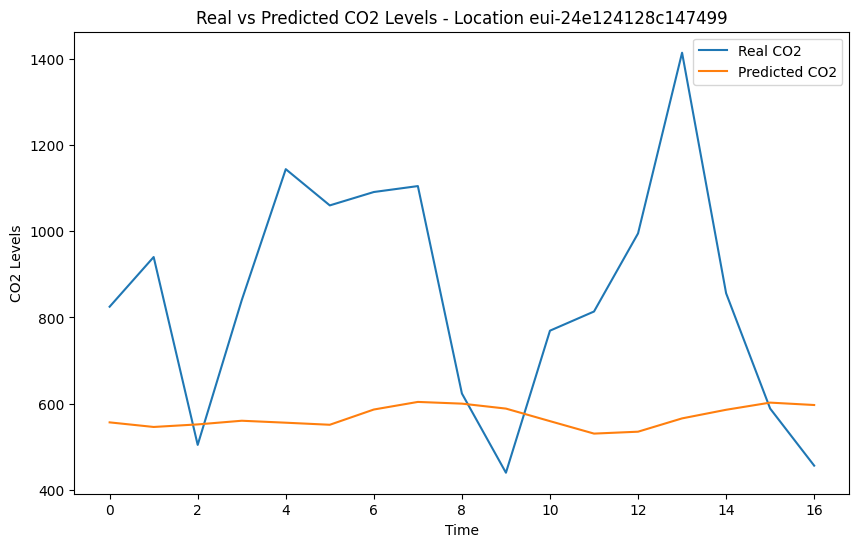

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0215 - val_loss: 0.0316
Epoch 2/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0215 - val_loss: 0.0314
Epoch 3/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0213 - val_loss: 0.0311
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0212 - val_loss: 0.0309
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0211 - val_loss: 0.0307
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0210 - val_loss: 0.0305
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0209 - val_loss: 0.0303
Epoch 8/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0208 - val_loss: 0.0300
Epoch 9/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0207 - val_loss: 0.0298
Epoch 10/100
1/1 [==============================] - 0s 63ms/step - loss: 0.0206 - val_loss: 0.0296
Epoch 11/100
1/1 [===

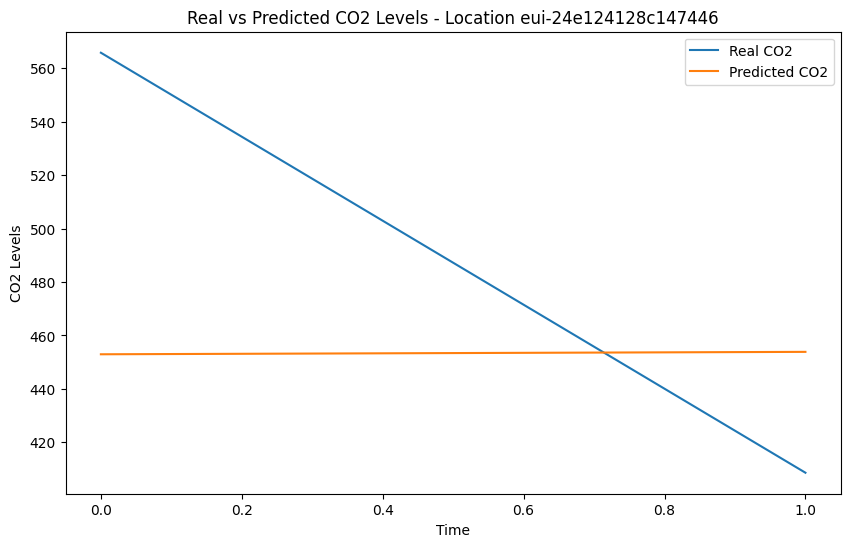

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0204 - val_loss: 0.0297
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0203 - val_loss: 0.0295
Epoch 3/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0202 - val_loss: 0.0294
Epoch 4/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0201 - val_loss: 0.0292
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0200 - val_loss: 0.0291
Epoch 6/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0199 - val_loss: 0.0289
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0198 - val_loss: 0.0287
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0198 - val_loss: 0.0286
Epoch 9/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0197 - val_loss: 0.0284
Epoch 10/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0197 - val_loss: 0.0282
Epoch 11/100
1/1 [===

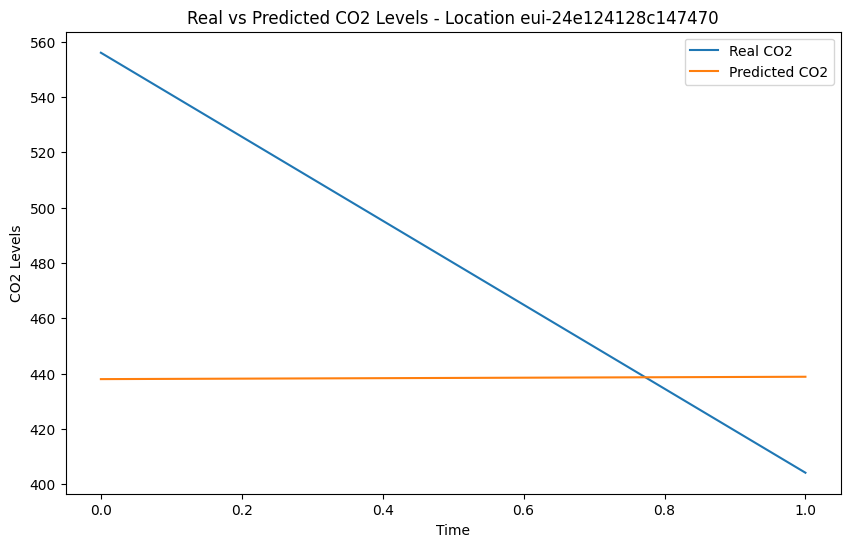

In [ ]:
from sklearn.model_selection import train_test_split

# Obtener los datos de CO2
co2_data = data_pivot.loc[:, ('co2')]

# Obtener las ubicaciones únicas
unique_locations = co2_data.index.get_level_values('location').unique()

# Definir parámetros LSTM
n_steps = 3  # número de pasos temporales

# Crear el modelo LSTM y hacer predicciones para cada ubicación
for location in unique_locations:
    # Filtrar datos por ubicación
    data_location = co2_data.loc[co2_data.index.get_level_values('location') == location]

    # Escalar datos específicos de la ubicación
    scaler_location = MinMaxScaler()
    data_scaled_location = scaler_location.fit_transform(data_location.values.reshape(-1, 1))

    # Preparar datos para LSTM
    X_co2_location, y_co2_location = prepare_data(data_scaled_location, n_steps)

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_co2_location, y_co2_location, test_size=0.2, shuffle=False)

    # Crear y compilar el modelo LSTM para esta ubicación
    model_co2_location = Sequential()
    model_co2_location.add(LSTM(370, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_co2_location.add(Dropout(0.2))
    model_co2_location.add(LSTM(370, activation='relu'))
    model_co2_location.add(Dropout(0.2))
    model_co2_location.add(Dense(1, kernel_regularizer=l2(0.01)))

    optimizer_location = Adam(learning_rate=0.0001)
    model_co2_location.compile(optimizer=optimizer_location, loss='mse')

    # Entrenar el modelo para esta ubicación
    history_location = model_co2_location.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

    # Predecir CO2 para esta ubicación
    predictions_co2_location = model_co2_location.predict(X_test)
    predictions_co2_location = predictions_co2_location.reshape(-1, 1)

    # Transformar las predicciones de vuelta a la escala original
    predictions_co2_location_inv = scaler_location.inverse_transform(np.concatenate((predictions_co2_location, np.zeros((len(predictions_co2_location), 2))), axis=1))[:, 0]

    # Imprimir las predicciones para esta ubicación
    print("Predictions CO2 for location", location, ":", predictions_co2_location_inv)

    y_co2_test_flat = scaler.inverse_transform(np.concatenate((y_test, np.zeros((len(y_test), 2))), axis=1))[:, 0]
    y_co2_test_flat = y_co2_test_flat.reshape(-1)

    # Graficar los datos reales y las predicciones para esta ubicación
    plt.figure(figsize=(10, 6))
    plt.plot(y_co2_test_flat, label='Real CO2')
    plt.plot(predictions_co2_location_inv, label='Predicted CO2')
    plt.title('Real vs Predicted CO2 Levels - Location {}'.format(location))
    plt.xlabel('Time')
    plt.ylabel('CO2 Levels')
    plt.legend()
    plt.show()


## Humidity

Epoch 1/100
24/24 [==============================] - 2s 38ms/step - loss: 0.1100 - val_loss: 0.0369
Epoch 2/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0496 - val_loss: 0.0402
Epoch 3/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 4/100
24/24 [==============================] - 1s 32ms/step - loss: 0.0478 - val_loss: 0.0371
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0482 - val_loss: 0.0365
Epoch 6/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0480 - val_loss: 0.0407
Epoch 7/100
24/24 [==============================] - 1s 39ms/step - loss: 0.0485 - val_loss: 0.0396
Epoch 8/100
24/24 [==============================] - 1s 47ms/step - loss: 0.0473 - val_loss: 0.0384
Epoch 9/100
24/24 [==============================] - 1s 43ms/step - loss: 0.0465 - val_loss: 0.0365
Epoch 10/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0461 - val_loss: 0.0363

6/6 [==============================] - 0s 15ms/step
Humidity predictions:
[0.27904707 0.3075508  0.44895214 0.31343588 0.26668057 0.41520512
 0.27475968 0.22976135 0.43806773 0.2319438  0.21131176 0.44255382
 0.21836291 0.21669573 0.42365313 0.2215667  0.21492298 0.42905247
 0.24530691 0.21559992 0.43110785 0.24829483 0.20834363 0.39421314
 0.21361047 0.21189727 0.4025893  0.23484306 0.19184138 0.37316695
 0.20982532 0.18047859 0.3715341  0.21226376 0.26510283 0.42100224
 0.2659086  0.22895123 0.41696894 0.24372853 0.12275133 0.39160696
 0.19959313 0.21506484 0.41057652 0.24953651 0.19121549 0.33587736
 0.24505349 0.17204934 0.36638364 0.21984278 0.13934936 0.3069349
 0.16498916 0.10077352 0.30500245 0.27215278 0.20690489 0.38209146
 0.32433417 0.25100756 0.3904048  0.23812921 0.16652533 0.33290532
 0.17975277 0.09631611 0.27804968 0.1517727  0.11684576 0.21732245
 0.26168138 0.3202483  0.326129   0.17107391 0.16637588 0.3028989
 0.17019027 0.3299406  0.23334076 0.14140889 0.16729283 0

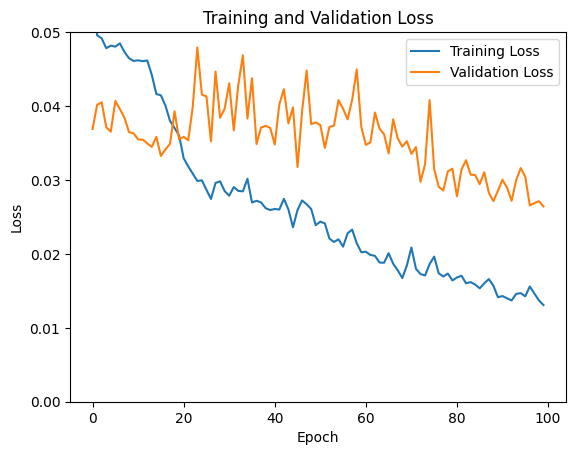

In [ ]:
import matplotlib.pyplot as plt

# Obtener el índice de la columna 'humidity'
humidity_index = list(data_pivot.columns).index('humidity')

# Preparar los datos para 'humidity'
X_humidity, y_humidity = prepare_data(data_scaled[:, humidity_index], n_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_humidity_train, X_humidity_test = X_humidity[:split], X_humidity[split:]
y_humidity_train, y_humidity_test = y_humidity[:split], y_humidity[split:]

# Reshape para incluir la dimensión de pasos de tiempo
X_humidity_train = X_humidity_train.reshape(X_humidity_train.shape[0], X_humidity_train.shape[1], 1)
X_humidity_test = X_humidity_test.reshape(X_humidity_test.shape[0], X_humidity_test.shape[1], 1)

# Definir y compilar el modelo
model_humidity = Sequential()
model_humidity.add(LSTM(370, activation='relu', input_shape=(X_humidity_train.shape[1], 1)))
model_humidity.add(Dropout(0.2))
model_humidity.add(Dense(1))
model_humidity.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model_humidity.fit(X_humidity_train, y_humidity_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_humidity_test, y_humidity_test))

# Obtener predicciones
predictions_humidity_scaled = model_humidity.predict(X_humidity_test)

# Invertir la transformación solo para la columna de humedad                        CAMBIAR ESTO
scaler_humidity = MinMaxScaler()
scaler_humidity.fit(y_humidity_test.reshape(-1, 1))
predictions_humidity_inv = scaler_humidity.inverse_transform(predictions_humidity_scaled).flatten()

print("Humidity predictions:")
print(predictions_humidity_inv)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 0.05)  # Adjust the y-axis range here
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse_humidity = mean_squared_error(y_humidity_test_inv, predictions_humidity_inv)
print("Mean Squared Error (Humidity):", mse_humidity)


NameError: name 'y_humidity_test_inv' is not defined

Temperature levels

In [ ]:
temperature_index = list(data_pivot.columns).index('temperature')  # Obtener el índice de la columna 'temperature'
X_temperature, y_temperature = prepare_data(data_scaled[:, temperature_index], n_steps)  # Preparar los datos para 'temperature'
X_temperature_train, X_temperature_test = X_temperature[:split], X_temperature[split:]
y_temperature_train, y_temperature_test = y_temperature[:split], y_temperature[split:]

# Reshape X_temperature_train y X_temperature_test para incluir la dimensión de pasos de tiempo
X_temperature_train = X_temperature_train.reshape(X_temperature_train.shape[0], X_temperature_train.shape[1], 1)
X_temperature_test = X_temperature_test.reshape(X_temperature_test.shape[0], X_temperature_test.shape[1], 1)

y_temperature_train = y_temperature_train.reshape(-1, 1)
y_temperature_test = y_temperature_test.reshape(-1, 1)

# Definir y compilar el modelo
model_temperature = Sequential()
model_temperature.add(LSTM(370, activation='relu', input_shape=(X_temperature_train.shape[1], 1)))
model_temperature.add(Dropout(0.2))
model_temperature.add(Dense(1))
model_temperature.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model_temperature.fit(X_temperature_train, y_temperature_train, epochs=100, batch_size=32, verbose=1)

# Obtener predicciones
predictions_temperature = model_temperature.predict(X_temperature_test)
predictions_temperature = predictions_temperature.reshape(-1, 1)

# Invertir la transformación para obtener las predicciones originales de la temperatura
predictions_temperature_inv = scaler.inverse_transform(np.concatenate((predictions_temperature, np.zeros((len(predictions_temperature), 2))), axis=1))[:, 0]
print("Temperature predictions:")
print(predictions_temperature_inv)


In [ ]:
import matplotlib.pyplot as plt

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model_humidity.fit(X_temperature_train, y_temperature_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_temperature_test, y_temperature_test), callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 0.01)  # Adjust the y-axis range here
plt.legend()
plt.show()


In [ ]:
# Print the predicted and ground truth CO2 values
# Inverse transform the ground truth for CO2
y_temperature_test_inv = scaler.inverse_transform(np.concatenate((y_temperature_test, np.zeros((len(y_temperature_test), 2))), axis=1))[:, 0]

# Print the predicted and ground truth CO2 values
print("Predicted Temperature\tGround Truth Temperature")
for pred, truth in zip(predictions_temperature_inv, y_temperature_test_inv):
    print('predictions:', pred, 'ground truth:', truth)


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse_temperature = mean_squared_error(y_temperature_test_inv, predictions_temperature_inv)
print("Mean Squared Error (Temperature):", mse_temperature)